In [16]:
import numpy as np 
import pandas as pd 

from itertools import product

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, f1_score, roc_auc_score, plot_precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN 
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.decomposition import PCA


import xgboost
import lightgbm

import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import seaborn as sns 

# Plotly 
import plotly.express as px 
import plotly.graph_objects as go 

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, word_tokenize

from collections import defaultdict

from lazypredict.Supervised import LazyClassifier

In [2]:
df = pd.read_csv('../data/processed/tanishq_data_clean_labelled.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

In [3]:
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()
df['clean_tweet_token'] = df['clean_tweet_segmented'].apply(lemmatizer.lemmatize).apply(tokenizer.tokenize)
df['clean_tweet_token'] = df['clean_tweet_token'].str.join(' ')

In [4]:
df = df[['clean_tweet_token', 'sentiment']]
df.dropna(inplace=True)
df = df[df['sentiment'].isin([0.0, 4.0])]
df['sentiment'] = df['sentiment'].replace({4.0: 1})

In [5]:
count_vec = CountVectorizer()
X_count_vec = count_vec.fit_transform(df['clean_tweet_token'])
#print(count_vec.get_feature_names())

In [6]:
y = df['sentiment'].values
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_count_vec.toarray(), y, test_size=0.25, random_state=42, stratify=y)

In [8]:
lr = LogisticRegression(random_state=42)
knn = KNN()
dt = DecisionTreeClassifier(random_state=42)
#xgb = xgboost.XGBClassifier()
#lgb = lightgbm.LGBMClassifier(random_state=42)
lda = LinearDiscriminantAnalysis()
svc = SVC(probability=True, random_state=42)
#lin_svc = LinearSVC(random_state=42)
#nu_svc = NuSVC(random_state=42)



In [9]:
classifiers = {'lr': lr, 'knn': knn, 'dt': dt,  'lda': lda, 'svc': svc} 

#'nu_svc': nu_svc, 'xgb': xgb, 'lgb': lgb, 'lin_svc': lin_svc

In [10]:
df_voting = pd.DataFrame(columns=classifiers.keys())
df_voting['true'] = y_test_cv

Average precision for lr: 0.05434782608695652
Accuracy for lr: 0.9456521739130435
F1 score for lr: 0.0
ROC AUC for lr: 0.5


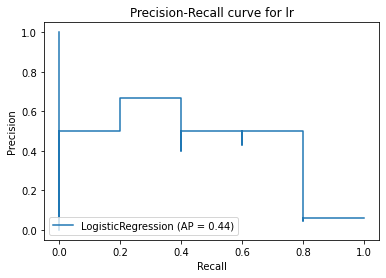

Average precision for knn: 0.05434782608695652
Accuracy for knn: 0.9456521739130435
F1 score for knn: 0.0
ROC AUC for knn: 0.5


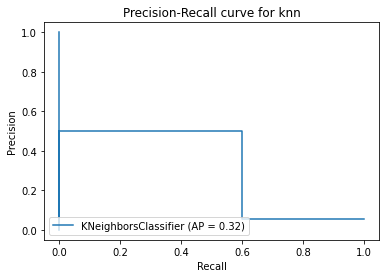

Average precision for dt: 0.14347826086956522
Accuracy for dt: 0.9456521739130435
F1 score for dt: 0.28571428571428575
ROC AUC for dt: 0.5942528735632183


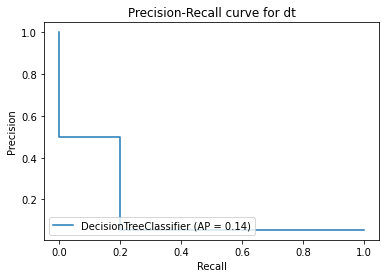

Average precision for lda: 0.17173913043478262
Accuracy for lda: 0.8804347826086957
F1 score for lda: 0.35294117647058826
ROC AUC for lda: 0.7482758620689656


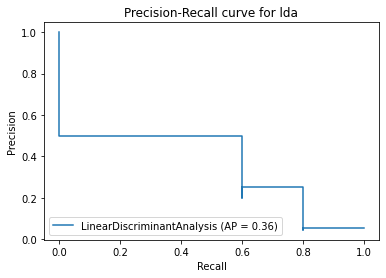

Average precision for svc: 0.05434782608695652
Accuracy for svc: 0.9456521739130435
F1 score for svc: 0.0
ROC AUC for svc: 0.5


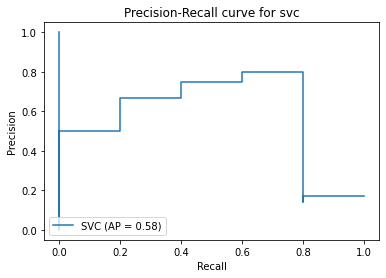

In [11]:
for clf in classifiers:
    classifiers[clf].fit(X_train_cv, y_train_cv)
    df_voting[clf] = classifiers[clf].predict(X_test_cv)
    print('Average precision for {}: {}'.format(clf, average_precision_score(df_voting['true'], df_voting[clf])))
    print('Accuracy for {}: {}'.format(clf, accuracy_score(df_voting['true'], df_voting[clf])))
    print('F1 score for {}: {}'.format(clf, f1_score(df_voting['true'], df_voting[clf])))
    print('ROC AUC for {}: {}'.format(clf, roc_auc_score(df_voting['true'], df_voting[clf])))
    disp = plot_precision_recall_curve(classifiers[clf], X_test_cv, y_test_cv)
    disp.ax_.set_title(f'Precision-Recall curve for {clf}')
    plt.show()
    

Average precision for vc: 0.05434782608695652
Accuracy for vc: 0.9456521739130435
F1 score for vc: 0.0
ROC AUC for vc: 0.5


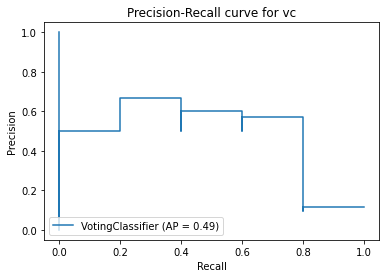

In [12]:
vc = VotingClassifier(estimators=list(classifiers.items()), voting='soft')

vc.fit(X_train_cv, y_train_cv)
df_voting['vc'] = vc.predict(X_test_cv)

print('Average precision for vc: {}'.format(average_precision_score(df_voting['true'], df_voting['vc'])))
print('Accuracy for vc: {}'.format(accuracy_score(df_voting['true'], df_voting['vc'])))
print('F1 score for vc: {}'.format(f1_score(df_voting['true'], df_voting['vc'])))
print('ROC AUC for vc: {}'.format(roc_auc_score(df_voting['true'], df_voting['vc'])))
disp = plot_precision_recall_curve(vc, X_test_cv, y_test_cv)
disp.ax_.set_title(f'Precision-Recall curve for vc')
plt.show()



In [13]:
classifiers['vc'] = vc 
classifiers

{'lr': LogisticRegression(random_state=42),
 'knn': KNeighborsClassifier(),
 'dt': DecisionTreeClassifier(random_state=42),
 'lda': LinearDiscriminantAnalysis(),
 'svc': SVC(probability=True, random_state=42),
 'vc': VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                              ('knn', KNeighborsClassifier()),
                              ('dt', DecisionTreeClassifier(random_state=42)),
                              ('lda', LinearDiscriminantAnalysis()),
                              ('svc', SVC(probability=True, random_state=42))],
                  voting='soft')}

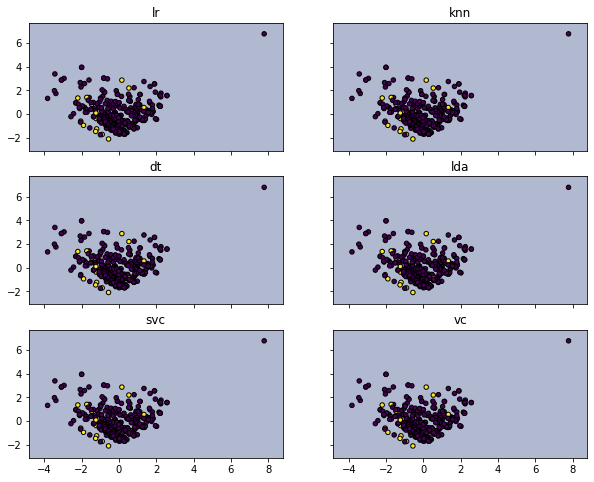

In [20]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_count_vec.toarray())

# Plotting decision regions
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1, 2], [0, 1]),
                        classifiers.values(),
                        classifiers.keys()):

    Z = clf.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X_pca[:, 0], X_pca[:, 1], c=df['sentiment'].values,
                                  s=20, edgecolor='k')
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()